In [ ]:
!pip install yfinance numpy pandas scikit-learn tensorflow keras-tuner scikit-optimize matplotlib

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import r2_score, explained_variance_score, classification_report, accuracy_score
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor

# Fetch the data
ticker_symbol = "MQG.AX"
westpac = yf.Ticker(ticker_symbol)
data = westpac.history(period="10y", interval="1wk")


In [3]:
# define target value (closing price of the next day)
data['Target'] = data['Close'].shift(-1) # -1 used to used next day's price as target
print(data)

                                 Open        High         Low       Close  \
Date                                                                        
2014-05-26 00:00:00+10:00   39.416552   39.416552   39.025968   39.078045   
2014-06-02 00:00:00+10:00   39.078040   39.442587   38.414045   39.123608   
2014-06-09 00:00:00+10:00   39.123618   39.572793   38.863229   39.045502   
2014-06-16 00:00:00+10:00   38.993430   39.833186   38.778607   39.384014   
2014-06-23 00:00:00+10:00   39.423070   39.813654   38.804643   39.357971   
...                               ...         ...         ...         ...   
2024-04-29 00:00:00+10:00  184.578419  184.862636  179.707422  180.168060   
2024-05-06 00:00:00+10:00  178.237300  189.733631  177.247425  189.420013   
2024-05-13 00:00:00+10:00  186.303348  189.959056  183.010280  187.058014   
2024-05-20 00:00:00+10:00  191.320007  196.179993  190.610001  192.210007   
2024-05-27 00:00:00+10:00  194.080002  194.449997  187.500000  188.369995   

In [6]:
# add indicators

# SMA-10
data['SMA_10'] = data['Close'].rolling(window=10).mean().shift(1)
# SMA 25
data['SMA_25'] = data['Close'].rolling(window=25).mean().shift(1)

# Momentum (Close price difference shifted by 1 to use previous day's data)
data['Momentum'] = data['Close'].diff().shift(1)

# Stochastic %K and %D using data up to the previous day
low_min = data['Low'].rolling(window=14).min().shift(1)
high_max = data['High'].rolling(window=14).max().shift(1)
data['Stochastic_%K'] = ((data['Close'].shift(1) - low_min) / (high_max - low_min)) * 100
data['Stochastic_%D'] = data['Stochastic_%K'].rolling(window=3).mean()

# RSI calculated from previous days
delta = data['Close'].diff(1).shift(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD calculation shifted to include only past data
exp1 = data['Close'].ewm(span=12, adjust=False).mean().shift(1)
exp2 = data['Close'].ewm(span=26, adjust=False).mean().shift(1)
macd = exp1 - exp2
signal = macd.ewm(span=9, adjust=False).mean()
data['MACD'] = macd
data['MACD_Signal'] = signal

# list of columns
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
           'Target', 'SMA_10', 'SMA_25', 'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI',
           'MACD', 'MACD_Signal']

# reorder columns to put 'Target' in the end
columns.remove('Target')
columns.append('Target')
data= data[columns]


In [7]:
# delete rows with null/nan values
data = data.dropna()

In [8]:
contains_nan = data.isna().any().any()
print("Contains NaN:", contains_nan)

num_rows_with_nan = data.isna().any(axis=1).sum()
print("Number of rows with NaN:", num_rows_with_nan)

Contains NaN: False
Number of rows with NaN: 0


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into features and target
features = scaled_data[:, :-1]
target = scaled_data[:, -1]
split_idx = int(len(features) * 0.7)
# Split the features into training and testing sets
X_train = features[:split_idx]
X_test = features[split_idx:]


# Split the target into training and testing sets
y_train = target[:split_idx]
y_test = target[split_idx:]

In [11]:



param_search = {
    'n_estimators': (100, 300),  # Number of trees
    'max_features': ['log2', 'sqrt'],  # Number of features considered for splitting at each leaf node
    'max_depth': [None] + list(np.arange(10, 31)),  # Maximum number of levels in each decision tree
    'min_samples_split': (2, 10),  # Minimum number of data points placed in a node before the node is split
    'min_samples_leaf': (1, 4)  # Minimum number of data points allowed in a leaf node
}

# Create a RandomForestRegressor object
rf_regressor = RandomForestRegressor(random_state=42)

# Create a BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=rf_regressor,
    search_spaces=param_search,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,  # Cross-validation splitting strategy
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit BayesSearchCV
bayes_search.fit(X_train, y_train)

# Get the best estimator
best_rf = bayes_search.best_estimator_



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\Kirill\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Kirill\anaconda3\Lib\site-

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Mean Squared Error: 0.057407557739328104
R2 Score: -7.620829971387311


In [12]:
model = best_rf
predictions = model.predict(X_test) # MQG.AX stock

# evaluation
y_pred = predictions
 # MQG.AX stock



explained_variance = explained_variance_score(y_test, predictions)
print("Explained Variance Score:", explained_variance)


# Mean Squared Error (MSE)
mse = MeanSquaredError()
mse.update_state(y_test, y_pred)
mse_result = mse.result().numpy()
print("Mean Squared Error (MSE):", mse_result)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse_result)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = MeanAbsoluteError()
mae.update_state(y_test, y_pred)
mae_result = mae.result().numpy()
print("Mean Absolute Error (MAE):", mae_result)

# r^2
r2 = r2_score(y_test, y_pred)
print("R^2 (Coefficient of Determination):", r2)

# Calculate Mean Bias Deviation (MBD)
def mean_bias_deviation(y_true, y_pred):
    differences = y_true - y_pred
    mbd = np.mean(differences)
    return mbd

# Calculate MBD for the test set
mbd = mean_bias_deviation(y_test, y_pred)
print("Mean Bias Deviation:", mbd)

Explained Variance Score: 0.3238204397205975
Mean Squared Error (MSE): 0.043402325
Root Mean Squared Error (RMSE): 0.20833224
Mean Absolute Error (MAE): 0.19885667
R^2 (Coefficient of Determination): -6.606298815161048
Mean Bias Deviation: 0.19885667037751717


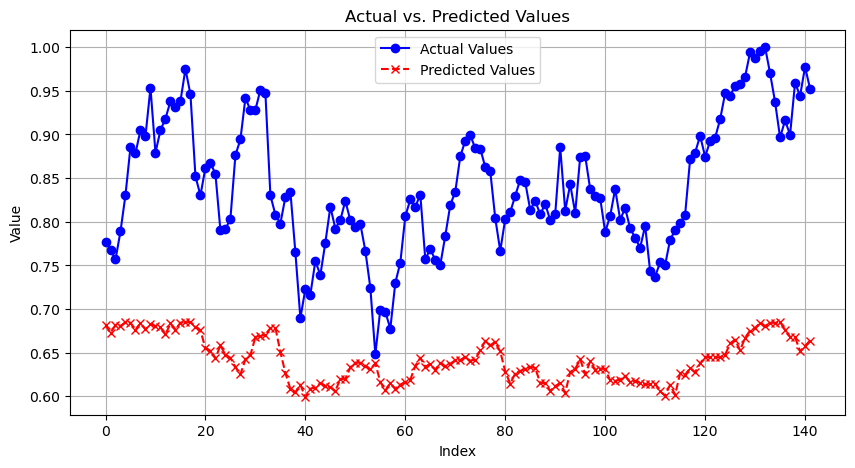

In [14]:
# plot results for macquarie group stock
y_test = np.array(y_test)
predictions = np.array(predictions)

plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue', marker='o')
plt.plot(range(len(predictions)), predictions, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()